### Mode Evaluator Example 

In [1]:
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison

# Load the regex model and the dataloader 
regex_m = RegexModel()
dataloader = AnnotationDataLoader()

regex_m.model_title = "Regex"
regex_m.model_info = "a"

# warp it model evaluator
## Evaluate model
# regex_m_wrapper = ModelEvalWrapper(regex_m, "Regex", "The baseline regex classifer")

In [ ]:
# regex_m_wrapper.predict(["asd", "asdadad"])

[2, 2]

In [2]:
import pandas as pd
t1 = dataloader.get_train()
t2 = dataloader.get_validation()
t3 = dataloader.get_test()

all = pd.concat([t1, t2, t3])

In [4]:
all

,protein_annotation,label
0,"Activator 1 36 kDa, putative",0
1,ARAD1C36740p,0
2,Abasic site processing protein YMR114C,2
3,Amino acid dehydrogenase,2
4,"Transcription regulator HTH, LysR",2
...,...,...
495,Anaerobic ribonucleoside-triphosphate reductas...,2
496,Beta-aspartyl asparaginyl family,2
497,Murein hydrolase activator NlpD,2
498,Outer membrane lipoprotein pcp,2



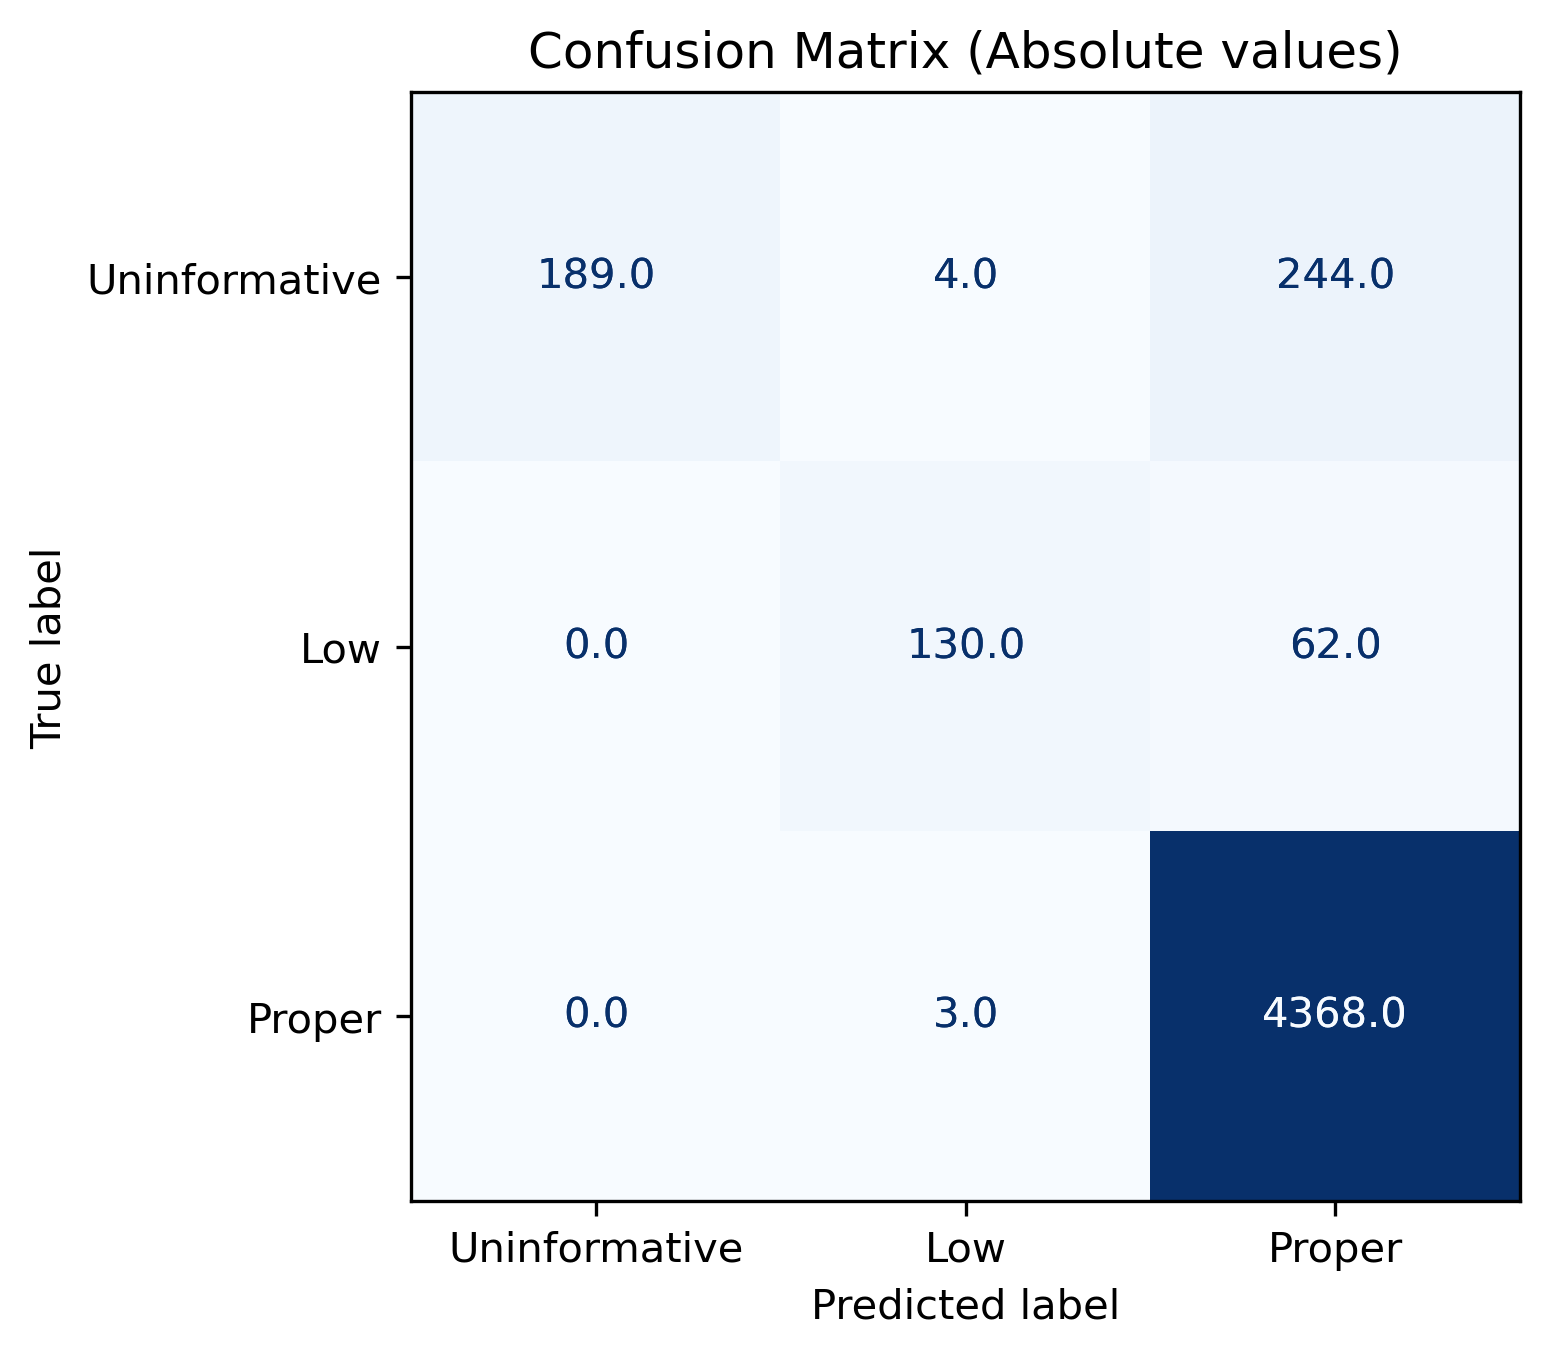
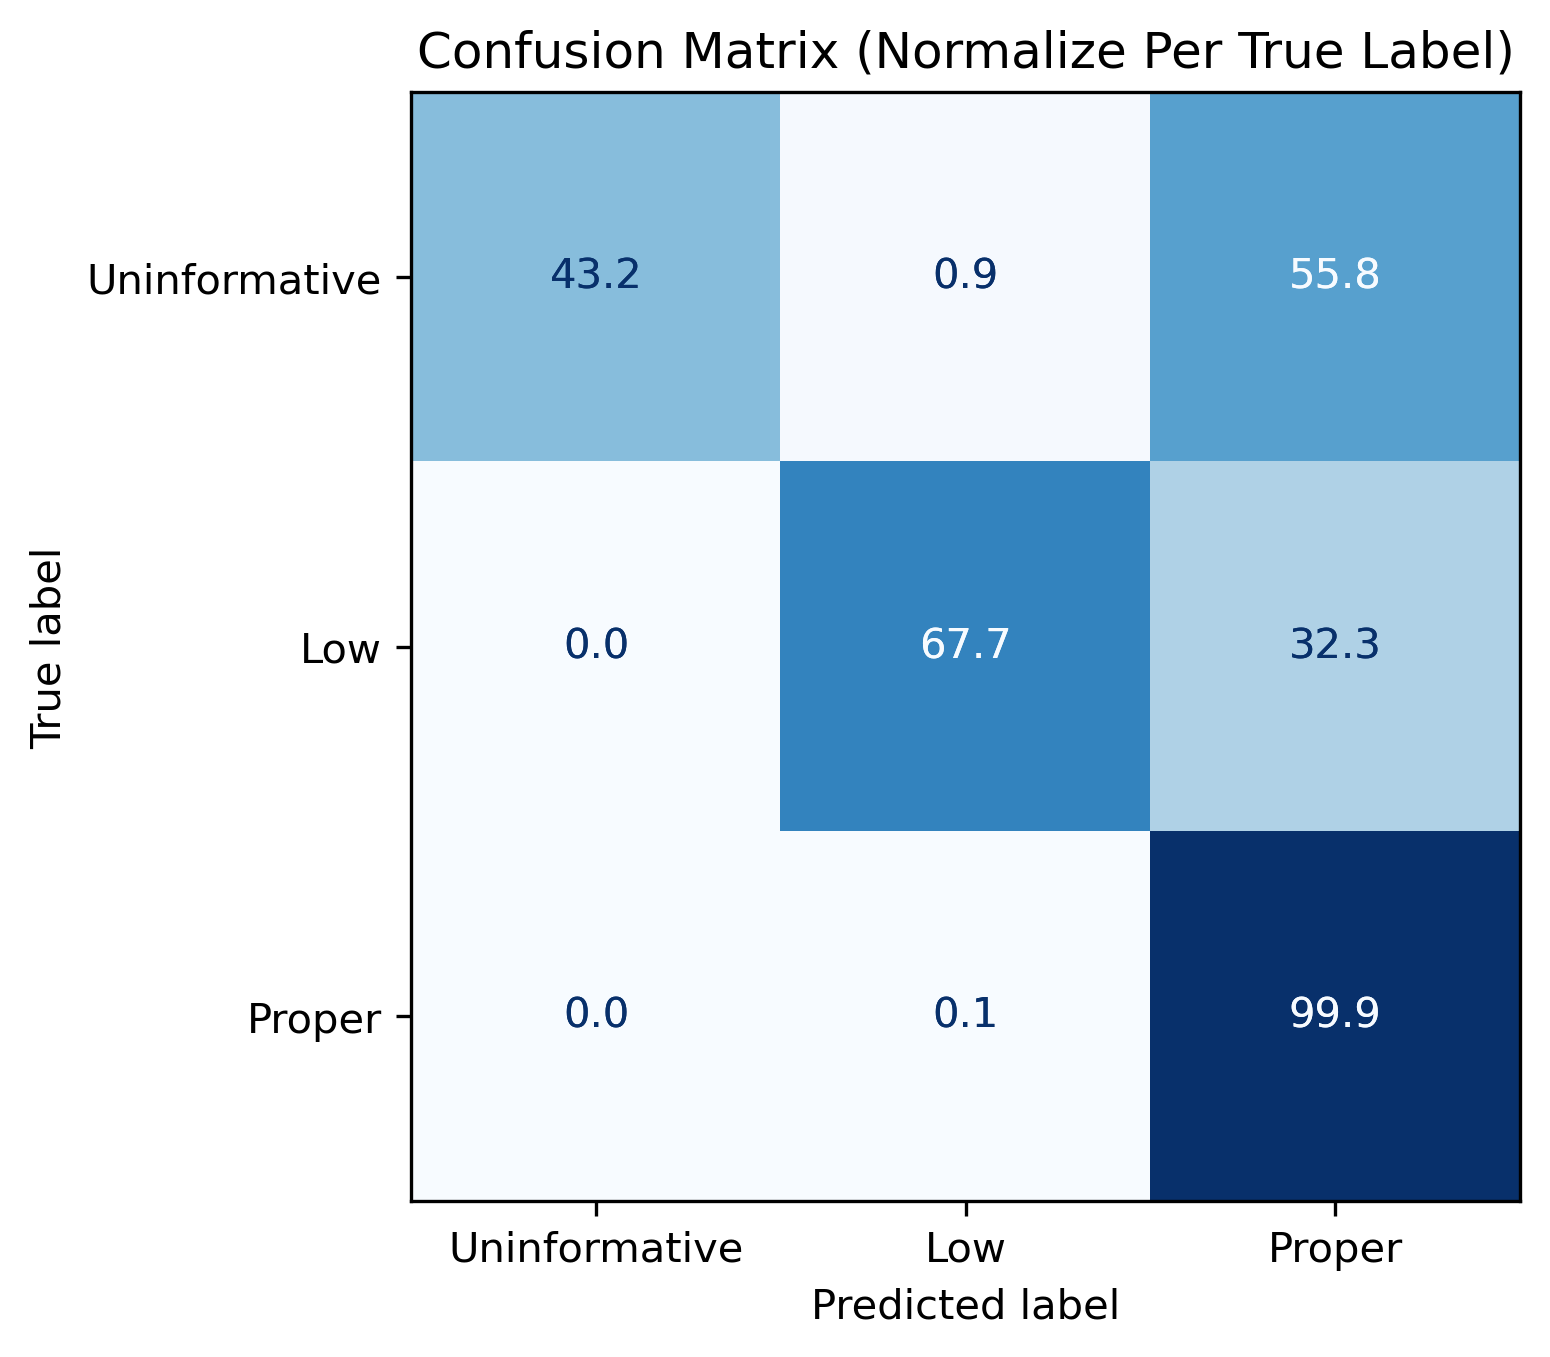

In [4]:
# regex model requrie no traning, so we can just predict on the eval set
# evaluator = ModelEvaluator(regex_m_wrapper, dataloader.get_train())
evaluator = ModelEvaluator(regex_m, all)

regex_report = evaluator.generate_report()
regex_report.show_report()

,protein_annotation,true_label,predicted_label
0,"Activator 1 36 kDa, putative",0,2
1,ARAD1C36740p,0,2
9,GD15429,0,2
12,"Uncharacterized conserved protein UCP015417, vWA",0,2
19,Poly,0,2
...,...,...,...
414,Phage-related J or K,0,2
435,BQ5605_C018g08736 protein,0,2
436,Uncharacterized gene 7.7 protein (Modular prot...,0,2
465,Leucine rich repeat 5,1,2


In [7]:
# # Save report to disk
# regex_report.save_to_file("report_regex.rep")

regex_report.eval_df != regex_report.eval_df 

,protein_annotation,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
495,False,False
496,False,False
497,False,False
498,False,False


In [2]:
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison

reg_report = ModelReport.load_report("report_regex.rep")
emb_report = ModelReport.load_report("embbeder_report.rep")
report_compare = ReportsComparison([reg_report, emb_report])


In [7]:
report_compare.get_comparison_df()

,Model,Accuracy,Average Time Per Prediction,Macro Average (precision),Macro Average (recall),Macro Average (f1-score),Macro Average (support),Weighted Average (precision),Weighted Average (recall),Weighted Average (f1-score),Weighted Average (support)
0,Regex,0.934857,0.000088,0.955693,0.687460,0.772890,3500.0,0.938311,0.934857,0.924245,3500.0
1,embedder,0.967000,0.007088,0.954138,0.870685,0.908821,1000.0,0.965998,0.967000,0.965683,1000.0


In [ ]:
reg_report = ModelReport.load_report("report_regex.rep")
emb_report = ModelReport.load_report("embbeder_report.rep")

report_compare.show_comparison_table()

In [ ]:
from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import AnnotationEmbedder
from models.embedder_with_classification_head.classification_heads import NeuralNetClassifier

from datetime import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier

import os
# --- Your defined search space ---
MLP_param_grid = {
    # MLP Param
    'hidden_layer_sizes': [(50,), (100, 50), (64, 32), (32,), (32, 16)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [500, 1000, 1500],
    "random_state": [42],

    # external params
    "train_with_sample_weights": [True, False],
    
    "embedder_name" : ["pritamdeka/S-PubMedBert-MS-MARCO",
        "NeuML/pubmedbert-base-embeddings",
        "pritamdeka/S-BioBert-snli-multinli-stsb",
        "all-MiniLM-L6-v2",
        "all-mpnet-base-v2",
        "sentence-transformers/all-MiniLM-L6-v2"
    ]

}

# --- Generate the configurations ---
configurations = list(ParameterGrid(MLP_param_grid))


REPORT_FOLDER = "reports"
if not os.path.exists(REPORT_FOLDER):
    os.makedirs(REPORT_FOLDER)


print(f"Total configurations to test: {len(configurations)}")

for i, config in enumerate(configurations):
    print(i)

    if i == 3:
        break
    
    print(config)

    info_str = f"EmbedderClassifier(AnnotationEmbedder, NeuralNetClassifier)|{str(config)}"

    train_with_sample_weights = config.pop("train_with_sample_weights")
    embedder_name = config.pop("embedder_name")
   
    embedder = AnnotationEmbedder(embedder_name)    
    classifier = NeuralNetClassifier(train_with_sample_weights=train_with_sample_weights, **config)

    embedder_m = EmbedderClassifier(embedder, classifier)

    model_title = ""

    embedder_m.model_title = "Embedder"
    embedder_m.model_info = info_str

    dataloader = AnnotationDataLoader()
    embedder_m.train(dataloader.get_train())

    filename_base = datetime.now().strftime(r"%Y%m%d_%H%M%S_Emebdder")

    m = ModelEvaluator(embedder_m, dataloader.get_validation())
    c_report = m.generate_report()
    # c_report.show_report()

    report_path = os.path.join(REPORT_FOLDER, f"{filename_base}_{embedder_m.model_title}.rep")
    c_report.save_to_file(report_path)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3974401302.py, line 24)

In [1]:
# comapre reports 
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison
import os
import glob
import pickle
REPORT_FOLDER = "reports"

search_path = os.path.join(REPORT_FOLDER, "*.rep")
all_reports_paths = glob.glob(search_path)
reports = []
for f in all_reports_paths:
    reports.append(ModelReport.load_report(f))


report_compare = ReportsComparison(reports)


,protein_annotation,true_label,predicted_label
28,Putative conserved protein,0,2
31,Uncharacterized homolog ofphage Mu protein gp47,2,0
35,Bordetella phage Bbp38 like protein,0,2
52,Protein A,0,2
56,LvrE,0,2
64,Uncharacterized protein with gpF-like domain,2,0
78,"CLUMA_CG001906, isoform A",0,2
91,Cell wall protein containing Ig-like domains (...,1,2
92,Extracellular protein,1,2
131,Aste57867_24821 protein,2,0


In [20]:
report_compare.show_comparison_plot()

In [18]:
r.eval_df[r.eval_df["protein_annotation"] == "Extracellular protein"]

,protein_annotation,label
92,Extracellular protein,1


In [19]:
import pandas as pd
all_misclassified = []
for r in report_compare._reports:
    all_misclassified.extend(list(r.show_misclassified_samples()["protein_annotation"]))
mc = pd.DataFrame(all_misclassified)
mc.value_counts()

0                                                          
Cell wall protein containing Ig-like domains (Group2 and 3)    989
Putative mobile element protein                                971
Uncharacterized protein YjbI, contains pentapeptide repeats    968
Aste57867_24821 protein                                        961
GH73                                                           960
                                                              ... 
Phage terminase small                                            1
DNA replication factor                                           1
Arac-type arabinose-binding/dimerisation domain                  1
Arm-DNA-bind_2 domain-containing protein                         1
CD200 receptor 1 like                                            1
Name: count, Length: 572, dtype: int64

In [ ]:

model_kwargs = {
    "hidden_layer_sizes":(64, 32),
    "activation":'relu',
    "solver":'adam',        # use Adam optimizer
    "learning_rate_init":0.001,
    "max_iter":500,
    "random_state":42
}

embedder = AnnotationEmbedder()
classifier = NeuralNetClassifier(train_with_sample_weights=True, **model_kwargs)
embedder_m = EmbedderClassifier(embedder, classifier)

embedder_m.model_title = "Embedder"
embedder_m.model_info = "Embedder"

dataloader = AnnotationDataLoader()
embedder_m.train(dataloader.get_train())





/data/leuven/368/vsc36835/conda_envs/ibp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
m = ModelEvaluator(embedder_m, dataloader.get_validation())
c_report = m.generate_report()
c_report.show_report()


In [ ]:

# from sklearn.neural_network import MLPClassifier

        
# embedder_m._classification_head =  MLPClassifier(hidden_layer_sizes=(64, 32),
#     activation='relu',
#     solver='adam',        # use Adam optimizer
#     learning_rate_init=0.001,
#     max_iter=500,
#     random_state=42)

# embedder_m.train(dataloader.get_train())

In [ ]:
m = ModelEvaluator(embedder_m, dataloader.get_validation())
c_report = m.generate_report()
c_report.show_report()

In [6]:
c_report.show_misclassified_samples(true_label_to_filter=2)

,protein_annotation,true_label,predicted_label
34,Putative bacteriophage regulatory protein,2,0
64,Uncharacterized protein with gpF-like domain,2,0
65,Cocosin 1,2,0
85,Rnr22p,2,0
130,Bacteriophage resistance protein,2,0
131,Aste57867_24821 protein,2,0
190,Bro-N domain-containing protein 019R,2,0
232,WD40 repeat domain protein,2,1
375,Phage eae protein,2,0
376,Bacteriophage/transposase fusion protein,2,0


In [ ]:
# len(embedder_m._embed(["asd"][0]))

384

In [ ]:
# c_report.save_to_file("embbeder_report")